# 1 Genetic Algorithm

A genetic algorithm is a method (search heuristic) inspired by natural evolution. The algorithm reflects the process of natural selection – the fittest individuals are selected for reproduction in order to produce offsprings of the next generation.

*Source:* [towardsdatascience.com](https://towardsdatascience.com/introduction-to-genetic-algorithms-including-example-code-e396e98d8bf3)

In the following report, we use the genetic algorithm to solve the **weighted form** of the **3-SAT problem**. The description of the problem can be found [here](https://moodle-vyuka.cvut.cz/mod/assign/view.php?id=89703).

## 1.1 Author of Report

* **Name:** Tomáš Patro
* **Username:** patrotom
* **Email:** patrotom@fit.cvut.cz

## 1.2 Algorithm Structure

In this section, we will briefly describe the base structure of the genetic algorithm we used in this report:

``` python
def genetic():
    prev_gen = init_generation()

    for it in range(0, gen_num):
        gen = []

        gen.append(find_elite(prev_gen))
        while len(gen) < len(prev_gen):
            parents = tournament(prev_gen)
            offsprings = crossover(parents)
            offsprings = mutate(offsprings)
            gen += offsprings

        prev_gen = gen
        pandemic()
        if it < gen_num / 2:
            war()
```

First, we start by initializing the first generation. The first generation is initialized by generating random configurations of the SAT problem. A particular instance determines the number of variables set to true. We represent the variables as a vector of $0$s (variable set to *false*) and $1$s (variable set to *true*). The number of random configurations corresponds to the given population size.

The number of `for` loop iterations corresponds to the given number of generations. In each iteration of the loop, we generate a new generation. First, we add the fittest individual from the previous generation to the next generation – we call this **elitism**. The generating is done in the nested `while` loop, which iterates until the whole population is generated (the number of individuals in all generations is the same). The generating consists of these three phases:

1. Selection (tournament)
2. Crossover (two-point)
3. Mutation (binary)

In addition to the standard genetic phases, I decided to add **two new custom phases**:

1. Pandemic
2. War

The solution is the fittest individual from the last generation. We extract this information later in the process.

### 1.2.1 Selection

In the first phase, we select two individuals for reproduction. We use the **tournament** strategy for this purpose. In this strategy, we take two samples of randomly selected five individuals. We take two fittest individuals from each sample. Again, we put these four individuals together and take the first two fittest, which become new parents.

The fitness function is calculated as follows:

* $n$ – number of variables
* $f$ – number of clauses evaluated to false
* $v_i$ – $1$ if variable is true, $0$ otherwise
* $w_i$ – weight of $i$th variable

$$
fitness=
\begin{cases}
-f \dots f > 0\\
\sum_{i=1}^{n} v_iw_i \dots otherwise\\
\end{cases}
$$

The fitness function we use ensures two things:

1. The individuals with **fewer clauses evaluated to false** are fitter.
2. The individuals with all clauses evaluated to true (valid configurations) are fitter if the **sum of the weights of true variables** is higher.

In this way, we try to **eliminate the invalid configurations** and **maximize the overall sum of the weights**. 

### 1.2.2 Crossover

The selected parents undergo the crossover with the given probability. If the parents do not undergo crossover, they are copied to the next generation. For the crossover, we use the **two-point** strategy. Individuals are split at two random points and recombined. The result of the crossover is two new offsprings (might be the same as parents).

### 1.2.3 Mutation

Each offspring undergo the mutation with the given probability. For the mutation, we use the **binary** strategy. It means that we flip one random bit in the offsprings' configuration.

### 1.2.4 Pandemic

Since pandemic is a hot topic nowadays, I decided to implement an extreme version of this event into the genetic algorithm. The algorithm tracks the development of maximum fitness throughout the generations. Since, commonly, the algorithm tends to get stuck in the local optimums, we add an event of a pandemic.

If the algorithm detects that the maximum fitness hasn't changed in 50 generations, it activates the pandemic. In this phase, the algorithm keeps only half of the **fittest individuals** and wipes out the other half. We generate the missing half by adding new random configurations. We add this phase on the premise that it could help us to escape the local optimums.

### 1.2.5 War

The war phase is similar to the pandemic. However, it can be activated only in the first half of the generations. The other preconditions are the same in the war as in the pandemic. However, in the war, we **randomly pick half of the individuals** and generate the missing half by adding new random configurations. The premise is the same as in the pandemic, but the approach is slightly different. We can activate this phase only in the first half to avoid wiping the fittest individuals sometime near the end of the generations loop.

# 2 Heuristic Evaluation

The evaluation of the heuristic is split into three steps:

1. Parameters tuning no. 1.
2. Parameters tuning no. 2.
3. Comparison of the basic, war, and pandemic versions.

In the report, we work with these parameters of the algorithm:

* $p$ – population size (`int`)
* $g$ – number of generations (`int`)
* $c$ – crossover probability ($c \in [0,1]$)
* $m$ – mutation probability ($m \in [0,1]$)

In addition, the version of the algorithm is determined by the following parameters:

* `war` – use the war version if set to true
* `pan` – use the pandemic version if set to true

If both `war` and `pan` parameters are set to false, we use the basic version of the algorithm.

We conduct both parameters tunings and algorithms comparison on these sets of configurations:

* `wuf20-88-A`
* `wuf20-78-M`
* `wuf20-78-Q`

We take the first $100$ configurations from each of the sets.

We look at the mean values of relative errors and execution times throughout the different sets of configurations. The relative errors are computed based on the given optimal solution weights.

## 2.1 Parameters Tuning 1

In the first tuning run, we try to find the best configuration of the **crossover** and **mutation** probabilities. We use the basic version of the algorithm. We fix the population size and number of generations:

* $p = 200$
* $g = 200$

## 2.2 Parameters Tuning 2

Based on the results from the previous tuning, we take the best configurations of the crossover and mutation probabilities. We use these values to tune the **number of generations** and **population size**. 

The result of these two tunings is the best configuration for the $p$, $g$, $c$, and $m$ parameters.

## 2.3 Algorithm Versions Comparison

In the last section, we compare the versions of the algorithm. As the base, we use the tuned parameters from the tuning runs. We experiment on how the elements of **war** and **pandemic** can affect the search for the optimal solution and look at the relative errors.

We compare the results of the mean relative errors and average execution times between the

1. *basic* version,
2. *war* version,
3. and *pandemic* version.

In the **war** version, we look at how the massive wipe of the random population can affect the escape from the local optimums. In the **pandemic** version, we look at the situation where there is a massive wipe of the population and keep the fittest individuals. We compare results from both versions with the **basic** version without any catastrophe at all.

# 3 Results Analysis

In the following section we look at the results of the heuristic evaluation we described in previous section. We measured the execution time for each run of the algorithm and saved the data to the CSV files. All execution times in this report were measured using the Python `timeit` module, which measures CPU time. The times you see in the following results are represented in **miliseconds \[ms\]**.

Computer configuration:

* **CPU:** Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
* **OS:** Linux Mint 19.2
* **Linux kernel:** 5.4.0-60-generic

Given:

* calculated weight $P$
* optimal weight $O$

We calculate the relative error $\epsilon$ as: $$\epsilon = \frac{|P - O|}{max\{O, P\}}$$

In the results below, we show the relative error **per mille ‰**.

We analyze the data using the *Python* language and its mathematical modules. The graphs and the whole report are rendered in the *Jupyter Notebook* – that's why we also add the code snippets in this report, which process data and generate the graphs. Data generated by the solution code are stored in the CSV format files, so we can easily load and process them.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [65]:
# Helper functions and configuration

plt.rcParams['figure.figsize'] = (16, 9)

# Data processing

def tune_data(dir_path, set_id):
    dir_path = f"../data/output/{dir_path}"
    dtypes = {"fname": str, "p": int, "g": int, "c": float, "m": float, "pan": bool, "war": bool}
    df = pd.read_csv(f"{dir_path}/{set_id}-opts.csv", sep=";", dtype=dtypes)
    
    d_dtypes = {"w_sum": int, "time": float, "rel_err": float, "conf": str}
    
    df["rel_err"] = 0.0
    df["time"] = 0.0
    
    for fname in df.fname:
        d_df = pd.read_csv(f"{dir_path}/{fname}", sep=";", dtype=d_dtypes)
        df.loc[df.fname == fname, "rel_err"] = float("{:.2f}".format(d_df.rel_err.mean() * 1000))
        df.loc[df.fname == fname, "time"] = float("{:.2f}".format(d_df.time.mean() * 1000))
    
    return df

def sat_data():
    data = {
        "c1": {
            "times": [],
            "rel_errs": []
        },
        "c2": {
            "times": [],
            "rel_errs": []
        },
        "c3": {
            "times": [],
            "rel_errs": []
        }
    }
    
    dtypes = {"w_sum": int, "time": float, "rel_err": float, "conf": str}
    
    for v in ["c1", "c2", "c3"]:
        for f in ["wuf-A/wuf20-88-A", "wuf-M/wuf20-78-M", "wuf-Q/wuf20-78-Q"]:
            fid = f.split("/")[1]
            fpath = f"../data/output/{v}/{f}/{fid}-sol-0.csv"
            df = pd.read_csv(fpath, sep=";", dtype=dtypes)
            data[v]["rel_errs"].append(float("{:.2f}".format(df.rel_err.mean() * 1000)))
            data[v]["times"].append(float("{:.2f}".format(df.time.mean() * 1000)))
    
    return data

# Graphs

def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    n_bars = len(data)
    bar_width = total_width / n_bars
    bars = []

    for i, (name, values) in enumerate(data.items()):
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])
            height = bar[0].get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar[0].get_x() + bar[0].get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
        
        bars.append(bar[0])

    if legend:
        ax.legend(bars, data.keys())

def time_graph(data, ax):
    graph_data = {
        "basic": data["c1"]["times"],
        "pandemic": data["c2"]["times"],
        "war": data["c3"]["times"]
    }

    labels = ["wuf20-88-A", "wuf20-78-M", "wuf20-78-Q"]
    x = np.arange(len(labels))
    ax.set_title(f"Average execution time by configurations set")
    
    ax.set_ylabel("Execution time [ms]")
    ax.set_xlabel("Configurations set")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.yscale("linear")

    bar_plot(ax, graph_data, total_width=.8, single_width=.9)

def err_graph(data, ax):
    graph_data = {
        "basic": data["c1"]["rel_errs"],
        "pandemic": data["c2"]["rel_errs"],
        "war": data["c3"]["rel_errs"]
    }

    labels = ["wuf20-88-A", "wuf20-78-M", "wuf20-78-Q"]
    x = np.arange(len(labels))
    ax.set_title(f"Mean relative error by configurations set")
    
    ax.set_ylabel("Relative error [‰]")
    ax.set_xlabel("Configurations set")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.yscale("log")

    bar_plot(ax, graph_data, total_width=.8, single_width=.9)

## 3.1 Tuning 1 Results

The parameters tuning no. 1 is described in the **Section 2.1**. We start by outputting the results from all three configurations sets:

In [25]:
tune_data("t1/wuf-M/wuf20-78-M", "wuf20-78-M")

,fname,p,g,c,m,pan,war,rel_err,time
0,wuf20-78-M-sol-0.csv,200,200,0.970,0.01,False,False,5.57,1335.85
1,wuf20-78-M-sol-1.csv,200,200,0.970,0.05,False,False,2.57,1426.75
2,wuf20-78-M-sol-2.csv,200,200,0.970,0.10,False,False,2.21,1402.01
3,wuf20-78-M-sol-3.csv,200,200,0.990,0.01,False,False,2.92,1324.75
4,wuf20-78-M-sol-4.csv,200,200,0.990,0.05,False,False,4.07,1449.31
5,wuf20-78-M-sol-5.csv,200,200,0.990,0.10,False,False,3.54,1401.80
6,wuf20-78-M-sol-6.csv,200,200,0.999,0.01,False,False,4.21,1294.49
7,wuf20-78-M-sol-7.csv,200,200,0.999,0.05,False,False,3.91,1458.88
8,wuf20-78-M-sol-8.csv,200,200,0.999,0.10,False,False,3.69,1417.26


In [27]:
tune_data("t1/wuf-Q/wuf20-78-Q", "wuf20-78-Q")

,fname,p,g,c,m,pan,war,rel_err,time
0,wuf20-78-Q-sol-0.csv,200,200,0.970,0.01,False,False,71.21,1509.58
1,wuf20-78-Q-sol-1.csv,200,200,0.970,0.05,False,False,58.55,1701.64
2,wuf20-78-Q-sol-2.csv,200,200,0.970,0.10,False,False,57.92,1822.54
3,wuf20-78-Q-sol-3.csv,200,200,0.990,0.01,False,False,67.07,1674.50
4,wuf20-78-Q-sol-4.csv,200,200,0.990,0.05,False,False,58.91,1845.62
5,wuf20-78-Q-sol-5.csv,200,200,0.990,0.10,False,False,63.55,1912.49
6,wuf20-78-Q-sol-6.csv,200,200,0.999,0.01,False,False,65.67,1783.04
7,wuf20-78-Q-sol-7.csv,200,200,0.999,0.05,False,False,56.71,1842.22
8,wuf20-78-Q-sol-8.csv,200,200,0.999,0.10,False,False,52.08,1925.45


In [28]:
tune_data("t1/wuf-A/wuf20-88-A", "wuf20-88-A")

,fname,p,g,c,m,pan,war,rel_err,time
0,wuf20-88-A-sol-0.csv,200,200,0.970,0.01,False,False,213.73,1760.80
1,wuf20-88-A-sol-1.csv,200,200,0.970,0.05,False,False,219.07,1890.86
2,wuf20-88-A-sol-2.csv,200,200,0.970,0.10,False,False,202.18,1891.31
3,wuf20-88-A-sol-3.csv,200,200,0.990,0.01,False,False,220.92,1946.25
4,wuf20-88-A-sol-4.csv,200,200,0.990,0.05,False,False,201.47,2005.28
5,wuf20-88-A-sol-5.csv,200,200,0.990,0.10,False,False,220.55,2085.93
6,wuf20-88-A-sol-6.csv,200,200,0.999,0.01,False,False,218.57,1958.31
7,wuf20-88-A-sol-7.csv,200,200,0.999,0.05,False,False,215.73,2031.60
8,wuf20-88-A-sol-8.csv,200,200,0.999,0.10,False,False,192.27,1727.62


We can see that the execution times are similar in all parameter configurations in all three sets, `M`, `Q`, and `A`. The relative error is smallest for the $c = 0.999$ and $m = 0.10$ for both `Q` and `A` sets. This fact doesn't hold for the `M` set. However, the difference between the relative errors in the `M` set is not that significant. We choose to pick these parameters for the next tuning run:

* $c = 0.999$
* $m = 0.10$

## 3.2 Tuning 2 Results

The parameters tuning no. 2 is described in the **Section 2.2**. We start by outputting the results from all three configurations sets:

In [29]:
tune_data("t2/wuf-M/wuf20-78-M", "wuf20-78-M")

,fname,p,g,c,m,pan,war,rel_err,time
0,wuf20-78-M-sol-0.csv,200,200,0.999,0.1,False,False,2.93,2282.51
1,wuf20-78-M-sol-1.csv,200,350,0.999,0.1,False,False,1.38,3972.78
2,wuf20-78-M-sol-2.csv,200,500,0.999,0.1,False,False,2.29,4809.39
3,wuf20-78-M-sol-3.csv,350,200,0.999,0.1,False,False,1.06,3561.89
4,wuf20-78-M-sol-4.csv,350,350,0.999,0.1,False,False,1.44,6475.20
5,wuf20-78-M-sol-5.csv,350,500,0.999,0.1,False,False,2.21,9242.72
6,wuf20-78-M-sol-6.csv,500,200,0.999,0.1,False,False,0.96,5158.44
7,wuf20-78-M-sol-7.csv,500,350,0.999,0.1,False,False,0.81,9022.74
8,wuf20-78-M-sol-8.csv,500,500,0.999,0.1,False,False,0.49,13633.72


In [30]:
tune_data("t2/wuf-Q/wuf20-78-Q", "wuf20-78-Q")

,fname,p,g,c,m,pan,war,rel_err,time
0,wuf20-78-Q-sol-0.csv,200,200,0.999,0.1,False,False,67.08,2176.60
1,wuf20-78-Q-sol-1.csv,200,350,0.999,0.1,False,False,63.38,4104.19
2,wuf20-78-Q-sol-2.csv,200,500,0.999,0.1,False,False,57.44,4826.57
3,wuf20-78-Q-sol-3.csv,350,200,0.999,0.1,False,False,42.92,3600.76
4,wuf20-78-Q-sol-4.csv,350,350,0.999,0.1,False,False,48.94,6541.09
5,wuf20-78-Q-sol-5.csv,350,500,0.999,0.1,False,False,43.47,9348.62
6,wuf20-78-Q-sol-6.csv,500,200,0.999,0.1,False,False,39.39,5209.69
7,wuf20-78-Q-sol-7.csv,500,350,0.999,0.1,False,False,39.80,9113.14
8,wuf20-78-Q-sol-8.csv,500,500,0.999,0.1,False,False,37.65,13746.64


In [31]:
tune_data("t2/wuf-A/wuf20-88-A", "wuf20-88-A")

,fname,p,g,c,m,pan,war,rel_err,time
0,wuf20-88-A-sol-0.csv,200,200,0.999,0.1,False,False,200.43,2441.96
1,wuf20-88-A-sol-1.csv,200,350,0.999,0.1,False,False,227.69,4260.76
2,wuf20-88-A-sol-2.csv,200,500,0.999,0.1,False,False,198.82,5403.24
3,wuf20-88-A-sol-3.csv,350,200,0.999,0.1,False,False,169.03,4077.15
4,wuf20-88-A-sol-4.csv,350,350,0.999,0.1,False,False,158.13,6912.84
5,wuf20-88-A-sol-5.csv,350,500,0.999,0.1,False,False,162.84,10148.33
6,wuf20-88-A-sol-6.csv,500,200,0.999,0.1,False,False,158.87,5697.81
7,wuf20-88-A-sol-7.csv,500,350,0.999,0.1,False,False,151.45,9881.93
8,wuf20-88-A-sol-8.csv,500,500,0.999,0.1,False,False,136.41,13436.02


We can see an interesting observation from the results above. The relative error rate lowers when the size of the population and number of generations rises. The interesting for us are the last three rows in each of the tables.

The relative errors in these three rows are similar. However, the mean relative error and execution time ratio is the most optimal for the 6th row. We decide to use this final configuration of the parameters:


* $p$ – $500$
* $g$ – $200$
* $c$ – $0.999$
* $m$ – $0.1$

## 3.3 Algorithms Comparison Results

In the following section, we look at the comparison between the **basic**, **war**, and **pandemic** version. This comparison is described in **Section 2.3**. The specifics of the algorithms are described in **Section 1.2.4** and **Section 1.2.5**. Let's start by looking at the average execution times:

In [69]:
data = sat_data()

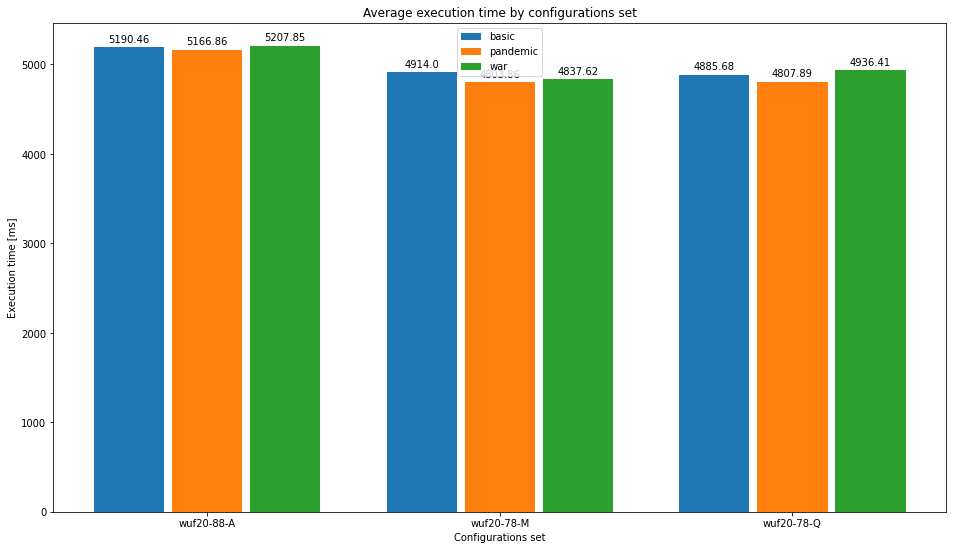

In [71]:
fig, ax = plt.subplots()
time_graph(data, ax)
plt.show()

From the graph above, we can see that the average execution times are almost identical in all three methods. There is only a slight variance, which is probably only caused by the OS and its current CPU load. We can conclude that our two new methods do not add unnecessary complexity to the algorithm, which would significantly slow it down. Now, let's look at the relative errors:

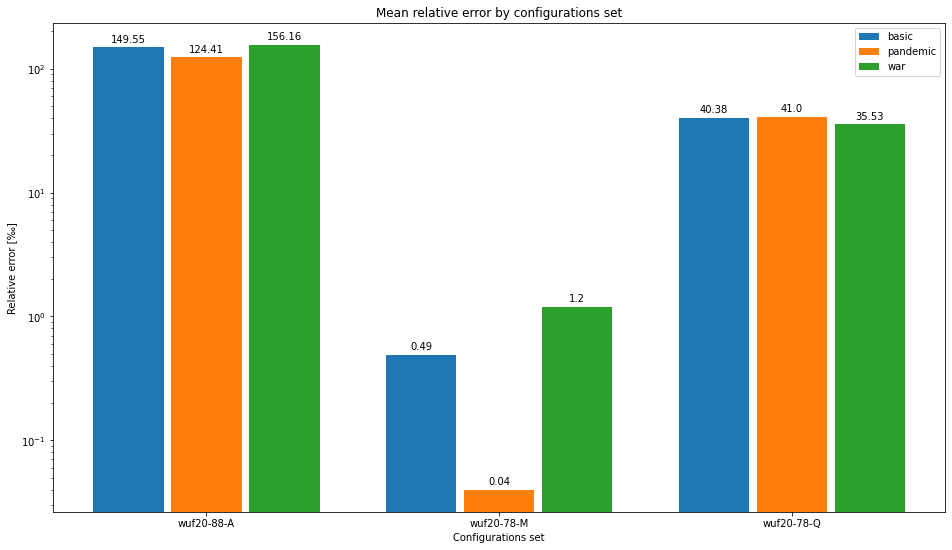

In [72]:
fig, ax = plt.subplots()
err_graph(data, ax)
plt.show()

In the `M` set, the pandemic phase significantly lowered the mean relative error. On the other hand, the war phase more than doubled the relative error comparing to the basic algorithm.

When we look at the `A` and `Q` sets, we don't see any significant progress in lowering the mean relative error. We can conclude that the proposed methods can work (pandemic in `M` set), but their success also depends on the particular set of configurations.

We can also conclude that the introduction of the massive randomness in the **pandemic** and even bigger randomness in the **war** phase does not necessarily worsen the overall solution but, on average, doesn't make it significantly better.

# 4 Conclusion

First, we explained the nature of the genetic algorithm and its connection with the Theory of evolution. We also described the basic structure of the algorithm we used in this report. We added the description of the used genetic mechanisms and briefly explained them (selection, crossover, mutation).

We introduced two new genetic mechanisms that come from the history of humankind – pandemic, and war. We implemented these two mechanisms on the premise that they would bring randomness to the algorithm, which would help us escape local optimums.

In the second part, we described the way we conducted the heuristic evaluation. We looked at the description of the process of parameters tuning and evaluation (comparison) of different types of algorithms – basic, pandemic, and war.

In the last part, we demonstrated the process of parameters tuning and how we had found the proper configuration of the algorithms' basic parameters – population size, number of generations, crossover probability, and mutation probability.

Then, we compared the average execution times and relative errors of the three versions of the algorithm. We concluded that the events of pandemic and war do not significantly affect the overall fitness of the population. We can relate this observation to our history, where the pandemics or wars didn't necessarily lead humankind to some evolutionary upgrade or degradation.